In [82]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, MinMaxScaler

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from mlxtend.frequent_patterns import apriori, association_rules

from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
#muitos imports que provem de muitos testes

In [83]:
train_df = pd.read_csv('train.csv')

In [84]:
# Remover colunas com muitos valores ausentes (identificados no EDA)
top_colunas_missing = ['PoolQC', 'MiscFeature', 'Alley', 'Fence']
imputer = SimpleImputer(strategy='constant', fill_value='None')
train_df = train_df.drop(columns=top_colunas_missing)

In [85]:
#preenchendo com none as onde falta caracteristica pra poder tratar esses campos de forma consistente 
cols_nones = ['FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
              'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
              'MasVnrType', 'MSZoning', 'Utilities', 'Functional', 'SaleType',
              'KitchenQual', 'Exterior1st', 'Exterior2nd', 'Electrical']

for col in cols_nones:
    train_df[col] = train_df[col].fillna('None')


In [86]:
#preenchendo valores ausentes com a mediana de cada coluna
mediana_coluna = ['MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
               'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea', 'LotFrontage', 'GarageYrBlt']

for col in mediana_coluna:
    train_df[col] = train_df[col].fillna(train_df[col].median())


In [89]:
#terminando o tratamento de dados,, contabiliznado valores nulos
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values_sorted = missing_values.sort_values(ascending=False)


In [97]:
#identifica os outliers
z_scores = np.abs(stats.zscore(train_df[numeric_cols]))

#usei 2 como base de limite pra capturar um numero maior de pontos
#nao funcionou, tive que voltar pro 3
outliers = np.where(z_scores > 3)


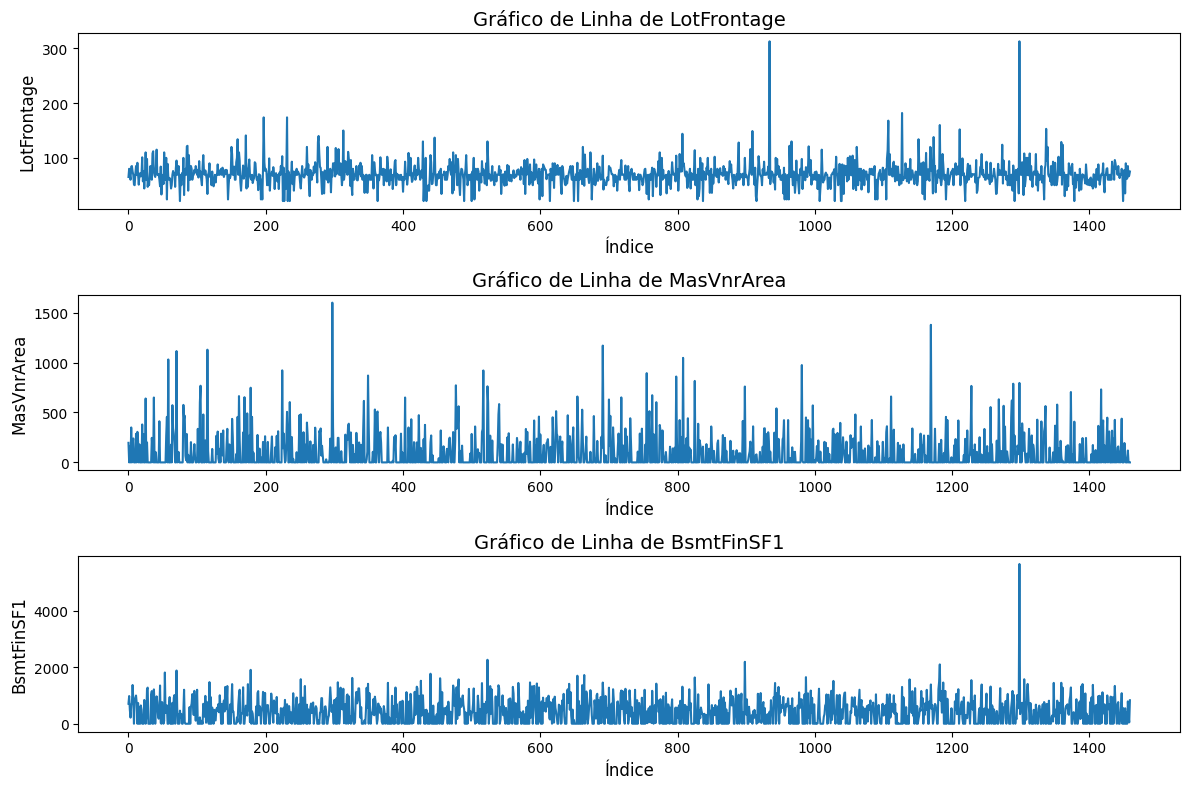

In [102]:
def plot_line(df, columns):
    num_plots = len(columns)
    fig, axes = plt.subplots(nrows=num_plots, figsize=(12, 8))

    for i, col in enumerate(columns):
        sns.lineplot(data=df[col], ax=axes[i])
        axes[i].set_title(f'Gráfico de Linha de {col}', fontsize=14)
        axes[i].set_xlabel('Índice', fontsize=12)
        axes[i].set_ylabel(col, fontsize=12)
        axes[i].tick_params(axis='both', labelsize=10)

    plt.tight_layout()
    plt.show()


plot_line(train_df, ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1'])


In [124]:
# Identificando colunas categórica
colunas_categoricas_treino = train_df.select_dtypes(include=['object']).columns.tolist()

# Aplicando codificação one-hot nas colunas
train_df_codificado = pd.get_dummies(train_df, columns=colunas_categoricas_treino, drop_first=True)

#head do formato 
print(f"Formato dos dados apos o one hot encoding: {train_df_codificado.shape}")
print("\nHead one hot encoding:")
print(train_df_codificado.head())


Formato dos dados apos o one hot encoding: (1460, 289)

Head one hot encoding:
   Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0   1          60         65.0     8450            7            5       2003   
1   2          20         80.0     9600            6            8       1976   
2   3          60         68.0    11250            7            5       2001   
3   4          70         60.0     9550            7            5       1915   
4   5          60         84.0    14260            8            5       2000   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  SaleType_New  SaleType_Oth  \
0          2003       196.0         706  ...         False         False   
1          1976         0.0         978  ...         False         False   
2          2002       162.0         486  ...         False         False   
3          1970         0.0         216  ...         False         False   
4          2000       350.0         655  ...         False  

In [125]:
X = train_df.drop('SalePrice', axis=1)#escolhendo features pro x
y = train_df['SalePrice'] #target (resposta) pra y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

# Treinamento
model = LinearRegression()
model.fit(X_train, y_train)

# Predição do conjunto teste
y_pred = model.predict(X_test)

#Grading do modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Erro médio quadrático:", mse)
print("R²:", r2)

#0.89 da pra melhorar

Erro médio quadrático: 648284481.0159011
R²: 0.8919819627363073


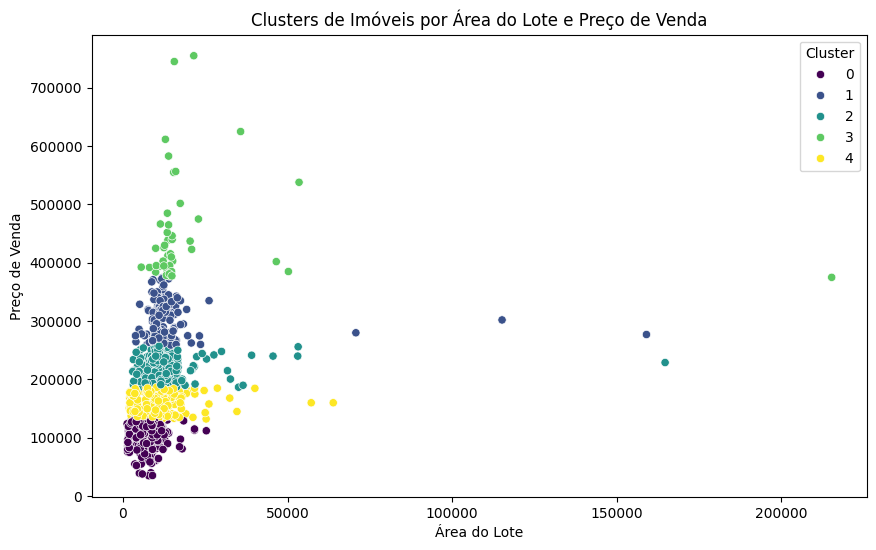

In [126]:
# Selecionando colunas numéricas para clusterização
numeric_cols = train_df.select_dtypes(include='number').columns

# Criando o objeto para o K-means com 5 clusters
kmeans = KMeans(n_clusters=5, random_state=0)

# Ajustando o modelo aos dados
kmeans.fit(train_df[numeric_cols])

# Adicionando os rótulos de cluster
train_df['Cluster'] = kmeans.labels_

# Visualizando a distribuição dos clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='LotArea', y='SalePrice', hue='Cluster', palette='viridis', data=train_df)
plt.title('Clusters de Imóveis por Área do Lote e Preço de Venda')
plt.xlabel('Área do Lote')
plt.ylabel('Preço de Venda')
plt.legend(title='Cluster')
plt.show()


#o cluster 3 tem altos preços de venda sem necessariamente tem uma area maior, #TODO checar o bairro onde fica ele ou outros fatores

In [127]:
# Centros de cluster
cluster_centers = pd.DataFrame(kmeans.cluster_centers_, columns=numeric_cols)
print("Cluster Centers:")
print(cluster_centers)

# Data points em cada cluster
cluster_counts = train_df['Cluster'].value_counts().sort_index()
print("\nCount of Data Points in Each Cluster:")
print(cluster_counts)


Cluster Centers:
           Id  MSSubClass  LotFrontage       LotArea  OverallQual  \
0  718.376590   58.053435    60.870229   7791.885496     4.854962   
1  703.282051   51.025641    81.397436  13981.621795     7.897436   
2  724.365625   54.718750    73.440625  11942.459375     6.856250   
3  691.250000   41.250000    89.613636  21590.000000     8.909091   
4  753.718464   60.274223    69.354662   9761.751371     5.811700   

   OverallCond    YearBuilt  YearRemodAdd  MasVnrArea   BsmtFinSF1  ...  \
0     5.603053  1946.371501   1969.720102   31.363868   256.407125  ...   
1     5.403846  1994.096154   2000.910256  238.391026   745.185897  ...   
2     5.390625  1988.875000   1996.325000  114.034375   451.984375  ...   
3     5.204545  1998.840909   2003.454545  431.068182  1058.727273  ...   
4     5.742230  1970.126143   1982.972578   83.323583   437.802559  ...   

   OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch      PoolArea  \
0    23.740458      36.422392   0.458015     4